## Optimising latent space dynamics for computational efficiency

Chemical kinetics

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ A_{ij} z_{j}+B_{ijk}z_jz_k
\end{equation}

In [5]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

from tqdm   import tqdm
from time   import time

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 200



In [6]:
def g(t, z, args):
    A, B = args
    return torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z)


def make_args(n_latent):
    A  = torch.randn(n_latent, n_latent)
    B  = torch.randn(n_latent, n_latent, n_latent)

    return A,B

def make_setup(z0, n_batch, n_latent):

    # Initial conditions
    t0 = 0.0

    # End time and time step
    t1 = 1.e0
    dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch


def solver(z0, args, atol, rtol, n_batch, n_latent,DEVICE):
    t_eval,z_0 = make_setup(z0, n_batch, n_latent)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data



In [17]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

n_latent = 10
n_batch  = 10000

atol = 1.0e-5
rtol = 1.0e-2

args = make_args(n_latent)

z0 = torch.rand(n_latent)*2-1

t,sol = solver(z0, args, atol, rtol, n_batch, n_latent, DEVICE)


In [22]:
t.shape

torch.Size([1, 100])

In [18]:
w = np.where(np.logical_or(np.abs(sol) > 15,np.isnan(sol)))

w

(array([   0,    0,    0, ..., 9999, 9999, 9999]),
 array([33, 33, 34, ..., 38, 38, 38]),
 array([0, 7, 0, ..., 5, 6, 7]))

In [19]:
idx = [0]
for i in range(1,len(w[0])):
    if w[0][i] != w[0][i-1]:
        idx.append(i)
print(len(idx),idx)
print(sol.shape)

9387 [0, 14, 24, 31, 34, 40, 41, 52, 53, 56, 71, 72, 82, 94, 101, 103, 104, 114, 126, 135, 149, 150, 151, 163, 166, 174, 177, 183, 184, 193, 203, 207, 216, 227, 236, 247, 260, 263, 272, 274, 275, 281, 286, 287, 294, 299, 307, 317, 329, 335, 338, 340, 345, 347, 353, 357, 364, 369, 374, 380, 386, 389, 391, 395, 407, 412, 424, 433, 443, 456, 460, 466, 472, 474, 476, 482, 484, 486, 492, 506, 512, 514, 519, 527, 533, 535, 541, 542, 546, 556, 558, 559, 563, 569, 571, 576, 583, 585, 592, 597, 599, 606, 613, 616, 621, 629, 636, 637, 641, 650, 662, 664, 672, 673, 685, 694, 697, 699, 702, 710, 712, 716, 721, 731, 733, 744, 745, 748, 750, 752, 758, 759, 767, 769, 776, 779, 781, 790, 801, 814, 823, 830, 836, 846, 849, 860, 863, 870, 882, 884, 886, 897, 899, 901, 908, 910, 912, 917, 920, 924, 930, 937, 948, 956, 959, 971, 974, 981, 989, 993, 999, 1007, 1018, 1024, 1033, 1034, 1042, 1045, 1048, 1051, 1052, 1053, 1055, 1056, 1062, 1066, 1070, 1073, 1080, 1089, 1095, 1102, 1110, 1117, 1123, 1127, 1129

100%|██████████| 9387/9387 [03:17<00:00, 47.54it/s]


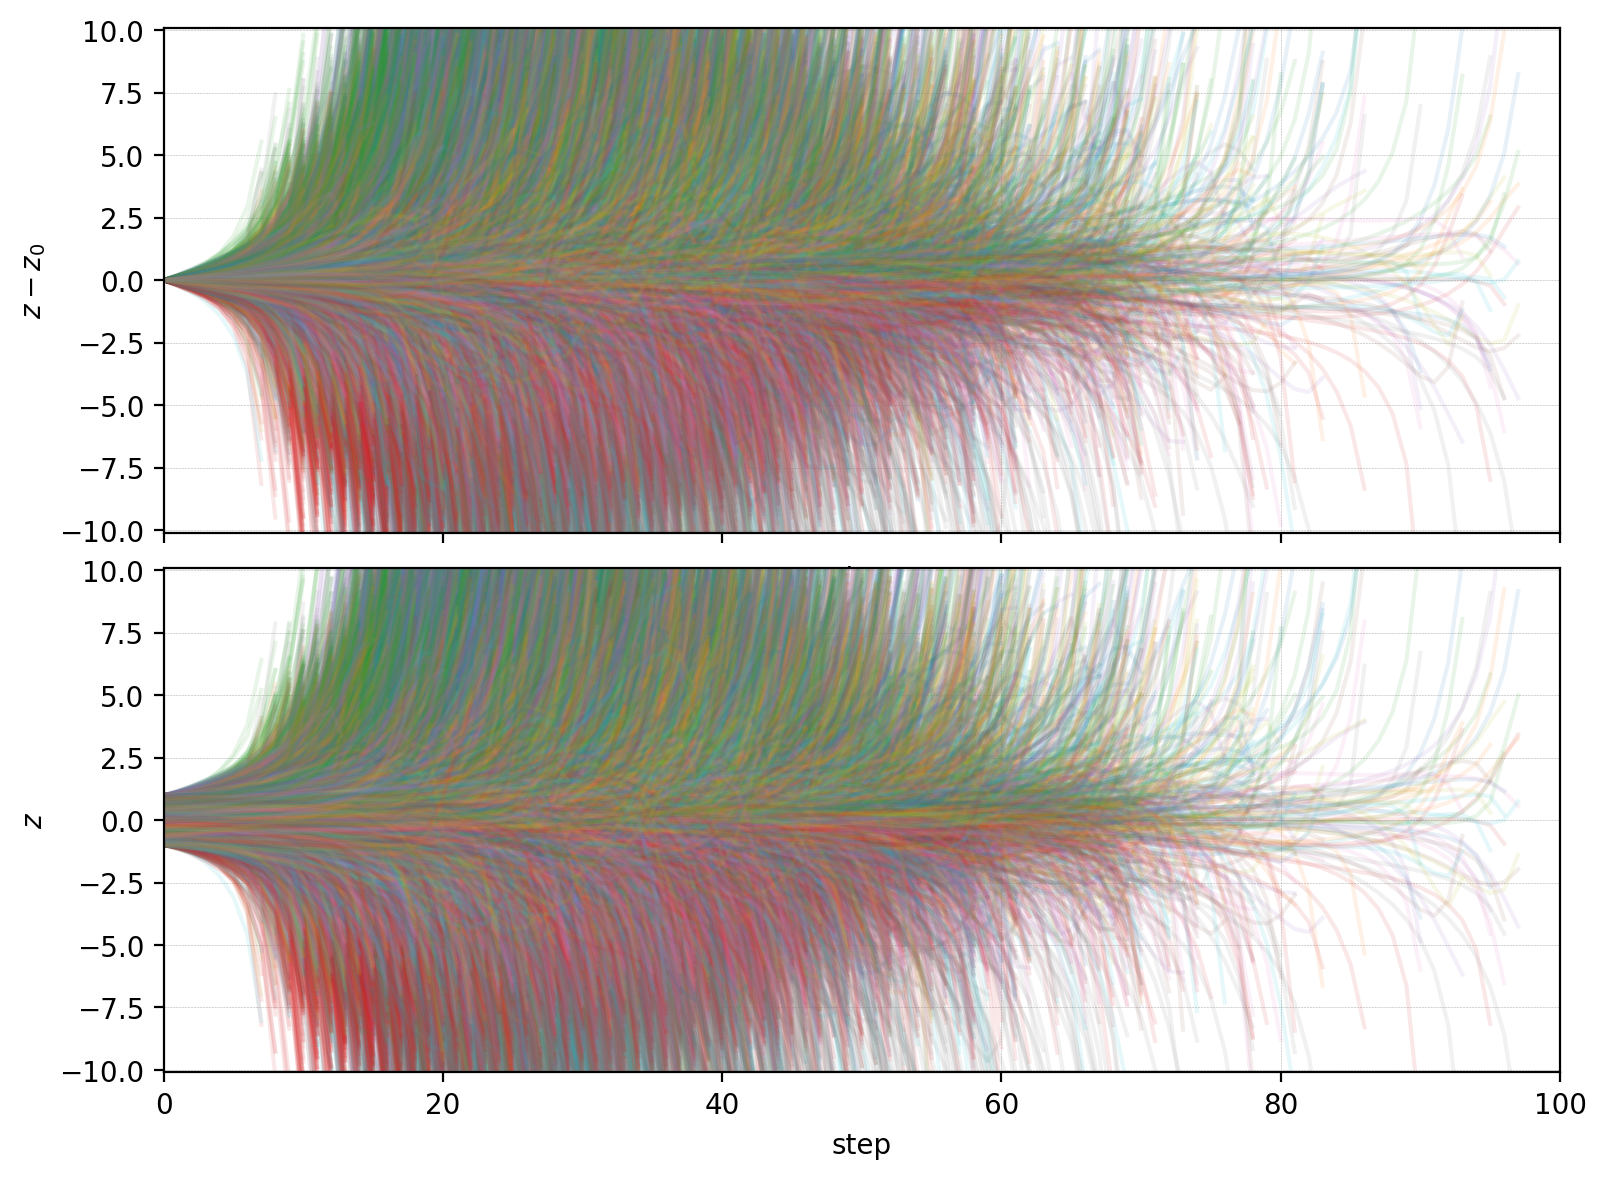

In [22]:
fig, axs = plt.subplots(2,1,figsize=(8,6))
ax1 = axs[0]
ax2 = axs[1]

a = 0.1

dyn = list()

step = 1
for n in tqdm(range(0,len(idx), step)):
    i = w[0][idx[n]]
    j = w[1][idx[n]]
    
    z = sol[i][:j]
    z0 = sol[i][0]
    Δz = z - z0
    dyn.append(Δz)


    ax1.plot(Δz, '-', alpha = a, label = i)
    ax2.plot(z, '-', alpha = a, label = i)


ax1.set_ylabel('$z-z_0$')
ax2.set_ylabel('$z$')

ylim = 10.1
xlim = 100
for ax in axs:
    ax.set_ylim([-ylim,ylim]) # type: ignore
    ax.set_xlim([0,xlim])
    ax.set_xlabel('step')
    ax.grid(True, linestyle = '--', linewidth = 0.2)
ax1.set(xticklabels=[])

fig.tight_layout()
fig.subplots_adjust(hspace = 0.07)


plt.show()

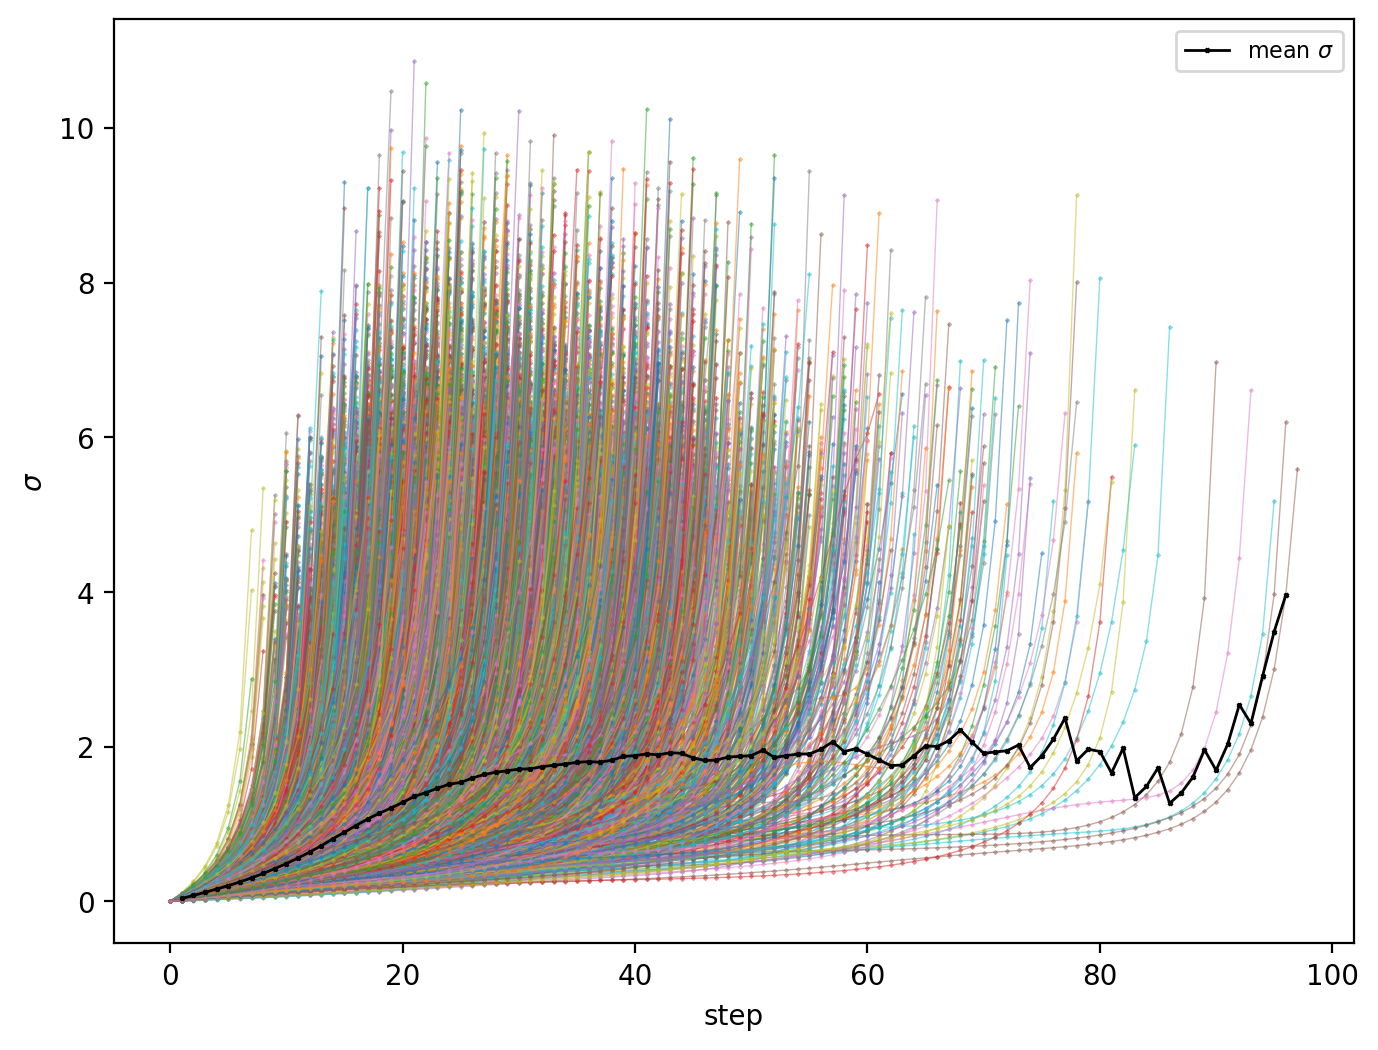

In [24]:
a = 0.5
fig, ax1 = plt.subplots(figsize=(8,6))

sigmas = np.zeros([len(idx),len(idx)])
for i in range(len(dyn)):
    sigma = torch.std(dyn[i], axis = 1)
    for j in range(len(sigma)-1):
        # print(j)
        sigmas[j][i] = sigma[j]

    ax1.plot(sigma, '-x', lw = 0.5, markersize = 1, alpha = a)


stds = list()
for i in range(len(sigmas)):
    mu = np.mean(sigmas[i][sigmas[i] != 0])
    stds.append(mu)

ax1.plot(stds, '-x', lw = 1, markersize = 1.5, color = 'k', label = 'mean $\\sigma$')

ax1.set_ylabel('$\\sigma$')
ax1.set_xlabel('step')
plt.legend(fontsize = 8)

plt.show()

torch.Size([100, 100]) torch.Size([100, 100, 10])


  0%|          | 0/100 [00:00<?, ?it/s]/lhome/silkem/anaconda3/envs/mace/lib/python3.10/site-packages/torch/_tensor.py:972: RuntimeWarning: invalid value encountered in cast
  return self.numpy().astype(dtype, copy=False)
100%|██████████| 100/100 [00:01<00:00, 66.80it/s]


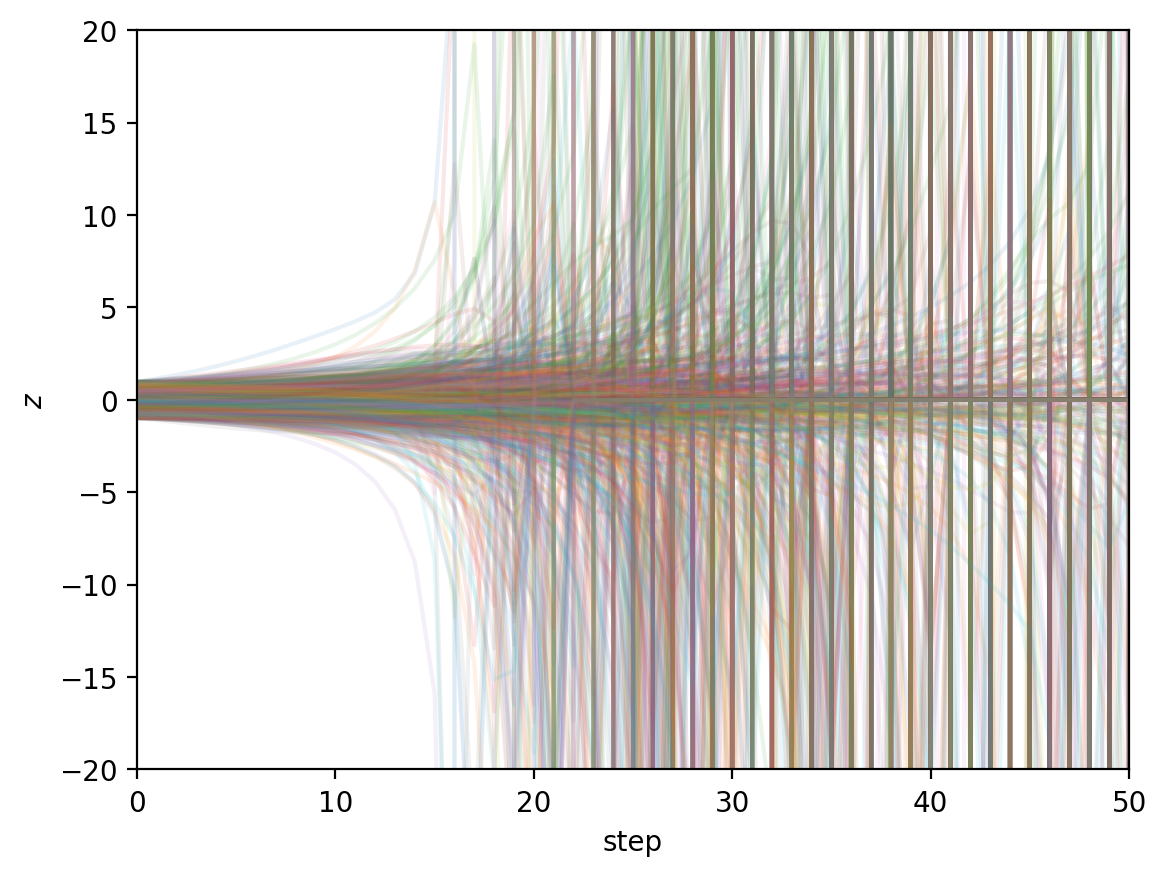

In [13]:
print(t.shape,sol.shape)

for i in tqdm(range(sol.shape[0])):
    plt.plot(sol[i], '-', alpha = 0.1)

plt.ylabel('$z$')
plt.xlabel('step')

plt.ylim([-20,20])
plt.xlim([0,50])

# plt.yscale('log')

plt.show()

### with NNs

In [5]:
class LatentODE(torch.nn.Module):
    
    def __init__(self, n_latent):
        
        super().__init__()
        
        self.n_latent = n_latent

        self.lin_1 = torch.nn.Linear(n_latent, n_latent)
        self.lin_2 = torch.nn.Linear(n_latent, n_latent)
        self.lin_3 = torch.nn.Linear(n_latent, n_latent)
        
        self.relu = torch.nn.LeakyReLU(0.2)
        self.sigm = torch.nn.Sigmoid()
        
    def forward(self, t, z):
        
        result = self.relu(self.lin_1(z))
        result = self.relu(self.lin_2(result))
        result = self.sigm(self.lin_3(result))
        
        return result
    
g = LatentODE(n_latent)

elapsed time: 0.017088890075683594
success?      True


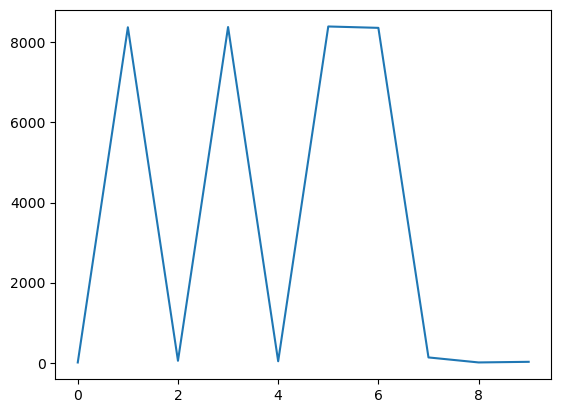

In [ ]:
# Setup solver
term                 = to.ODETerm(g.forward)#, with_args=True)
step_method          = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
# step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

# Compile solver\n",
jit_solver = torch.compile(solver)


# Setup initial value problem\n",
problem = to.InitialValueProblem(y0=z0_batch, t_eval=t_eval_batch)

# Run solver\n",
wct =- time()
solution = jit_solver.solve(problem, args=args)
# solution =     solver.solve(problem)#, args=args)
wct += time()
print("elapsed time:", wct)
print("success?     ", torch.all(solution.status == 0).item())

yt_torch = solution.ys[0][-1].detach().numpy()

plt.plot(yt_torch)